In [1]:
import os

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TFHUB_CACHE_DIR"]="tfhub_modules"

torch.manual_seed(1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

Using TensorFlow backend.


In [2]:
from allennlp.data.tokenizers.word_tokenizer import WordTokenizer
from allennlp.modules.elmo import batch_to_ids

NUM_WORDS = 20000

class ISEARDataset(object):
    FILENAME = "data/isear_databank.csv"
    EMOTION_CLASSES = ["anger", "disgust", "fear", "guilt", "joy", "sadness", "shame"]
    EMOTION_CLASSES_DICT = {"anger": 0, "disgust": 1, "fear": 2, "guilt": 3, "joy": 4, "sadness": 5, "shame": 6}
    RANDOM_STATE = 41
  
    def get_classes(self):
        return self.EMOTION_CLASSES
  
    def get_classes_dict(self):
        return self.EMOTION_CLASSES_DICT
    
    def _tokens_to_texts(self, tokens):
        texts = []
        for token in tokens:
            texts.append([t.text for t in token])
        return texts

    def _sequence_texts(self, texts):
        tokenizer = WordTokenizer()
        tokens = tokenizer.batch_tokenize(texts)
        sequences = batch_to_ids(self._tokens_to_texts(tokens))
        return sequences

    def __init__(self, n_items=0):
        data = pd.read_csv(self.FILENAME)

        if n_items > 0:
            data = data.iloc[0:n_items,:]

        data["text"] = data["SIT"]
        data["emotion"] = data["Field1"]

        for emotion in self.get_classes():
            data.loc[data["emotion"] == emotion, "emotion_int"] = self.get_classes_dict()[emotion]

        self.X = self._sequence_texts(data["text"]).numpy()
        self.y = data["emotion_int"].values

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [3]:
dataset = ISEARDataset()
# dataset = ISEARDataset(200)
X_train, X_test, y_train, y_test = train_test_split(dataset.X, dataset.y, test_size=0.3, random_state=dataset.RANDOM_STATE, stratify=dataset.y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=dataset.RANDOM_STATE, stratify=y_train)

In [4]:
print("X_train.shape: (%d, %d, %d)" % X_train.shape)
print("y_train.shape: (%d)" % y_train.shape)

print("X_valid.shape: (%d, %d, %d)" % X_valid.shape)
print("y_valid.shape: (%d)" % y_valid.shape)

print("X_test.shape: (%d, %d, %d)" % X_test.shape)
print("y_test.shape: (%d)" % y_test.shape)

X_train.shape: (4292, 201, 50)
y_train.shape: (4292)
X_valid.shape: (1074, 201, 50)
y_valid.shape: (1074)
X_test.shape: (2300, 201, 50)
y_test.shape: (2300)


In [5]:
np.save("pytorch_isear_X_train_elmo.npy", X_train)
np.save("pytorch_isear_X_valid_elmo.npy", X_valid)
np.save("pytorch_isear_X_test_elmo.npy", X_test)

np.save("pytorch_isear_y_train_elmo.npy", y_train)
np.save("pytorch_isear_y_valid_elmo.npy", y_valid)
np.save("pytorch_isear_y_test_elmo.npy", y_test)

In [6]:
X_train = np.load("pytorch_isear_X_train_elmo.npy")
X_valid = np.load("pytorch_isear_X_valid_elmo.npy")
X_test = np.load("pytorch_isear_X_test_elmo.npy")

y_train = np.load("pytorch_isear_y_train_elmo.npy")
y_valid = np.load("pytorch_isear_y_valid_elmo.npy")
y_test = np.load("pytorch_isear_y_test_elmo.npy")

In [7]:
dic = dataset.get_classes_dict()
labels = dataset.get_classes()
n_classes = len(labels)
print("class dictionary: %s" % dic)
print("class labels: %s" % labels)
print("number of bins: %s" % n_classes)

class dictionary: {'anger': 0, 'disgust': 1, 'fear': 2, 'guilt': 3, 'joy': 4, 'sadness': 5, 'shame': 6}
class labels: ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']
number of bins: 7


bins: [0, 1, 2, 3, 4, 5, 6, 7]


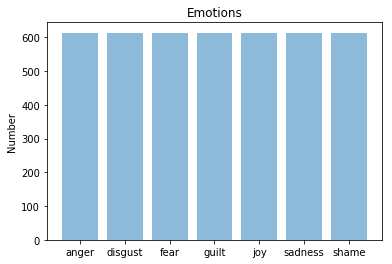

In [8]:
bins = list(range(0, n_classes + 1))
print("bins:", bins)
hist, _ = np.histogram(y_train, bins=bins)

y_pos = np.arange(len(labels))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

In [9]:
from torch import autograd

def make_one_hot(labels, C=2):
    '''
    Converts an integer label torch.autograd.Variable to a one-hot Variable.
    
    Parameters
    ----------
    labels : torch.autograd.Variable of torch.cuda.LongTensor
        N x 1 x H x W, where N is batch size. 
        Each value is an integer representing correct classification.
    C : integer. 
        number of classes in labels.
    
    Returns
    -------
    target : torch.autograd.Variable of torch.cuda.FloatTensor
        N x C x H x W, where C is class number. One-hot encoded.
    '''
    one_hot = torch.FloatTensor(labels.size(0), C, labels.size(2), labels.size(3)).zero_()
    target = one_hot.scatter_(1, labels.data, 1)
    
    target = autograd.Variable(target)
        
    return target
  
y = torch.LongTensor(y_train).view(-1, 1, 1, 1)
print("y.shape:", y.shape)
y_onehot = make_one_hot(y, C=7)
print("y_onehot.shape:", y_onehot.shape)

y.shape: torch.Size([4292, 1, 1, 1])
y_onehot.shape: torch.Size([4292, 7, 1, 1])


In [10]:
import torch
from torch.utils import data

class ISEAR_Tensor_Dataset(data.TensorDataset):
  
  def __init__(self, text, emotion, num_class=2):
    X = torch.LongTensor(text)
    y = torch.LongTensor(emotion).view(-1, 1, 1, 1)
    y_onehot = make_one_hot(y, num_class)
    y_onehot = y_onehot.view(y_onehot.shape[0], y_onehot.shape[1])
    tensors = []
    tensors.append(X)
    tensors.append(y_onehot)
    super().__init__(*tensors)

In [11]:
train_dataset = ISEAR_Tensor_Dataset(X_train, y_train, num_class=7)
valid_dataset = ISEAR_Tensor_Dataset(X_valid, y_valid, num_class=7)
test_dataset = ISEAR_Tensor_Dataset(X_test, y_test, num_class=7)

In [12]:
print("train_dataset.tensors[0].shape:", train_dataset.tensors[0].shape)
print("train_dataset.tensors[1].shape:", train_dataset.tensors[1].shape)

train_dataset.tensors[0].shape: torch.Size([4292, 201, 50])
train_dataset.tensors[1].shape: torch.Size([4292, 7])


In [13]:
print("train_dataset length:", len(train_dataset))
print("valid_dataset length:", len(valid_dataset))
print("test_dataset length:", len(test_dataset))

train_dataset length: 4292
valid_dataset length: 1074
test_dataset length: 2300


In [14]:
batch_size = 50

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Load Elmo

In [15]:
from allennlp.modules.elmo import Elmo, batch_to_ids

options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

# Compute two different representation for each token.
# Each representation is a linear weighted combination for the
# 3 layers in ELMo (i.e., charcnn, the outputs of the two BiLSTM))
elmo = Elmo(options_file, weight_file, num_output_representations=2, dropout=0)
elmo = elmo.to(device)

In [16]:
shape = train_dataset[0][0].shape
print("shape:", shape)
experiment_X_train = train_dataset[0][0].view(1, shape[0], shape[1]).to(device)
print("experiment_X_train.shape:", experiment_X_train.shape)

embedded = elmo(experiment_X_train)
print("embedded shape:", embedded['elmo_representations'][0].shape)

shape: torch.Size([201, 50])
experiment_X_train.shape: torch.Size([1, 201, 50])
embedded shape: torch.Size([1, 201, 1024])


In [17]:
import scipy

sentences = [
  ["I", "ate", "an", "apple", "for", "breakfast"], 
  ["I", "ate", "a", "carrot", "for", "breakfast"]
]
character_ids = batch_to_ids(sentences)

embeddings = elmo(character_ids.to(device))
embeddings['elmo_representations'][0][0]

tensor([[-1.0745, -0.5283, -0.2177,  ..., -0.6874,  0.0337,  0.1065],
        [-0.2210, -0.1498,  0.6300,  ...,  0.4575,  0.2636,  0.6487],
        [ 0.0527, -0.4137, -0.1914,  ...,  0.0653, -0.3125,  0.5624],
        [ 0.7515, -0.4722,  0.8008,  ..., -0.1728,  0.2715,  1.1177],
        [-0.2145, -0.3570,  0.1599,  ..., -0.0838, -0.4250,  0.4586],
        [-0.3339, -0.3030,  0.4855,  ..., -0.0636, -0.4033,  0.4355]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [18]:
vector1 = embeddings['elmo_representations'][0][0].cpu().detach().numpy()
vector2 = embeddings['elmo_representations'][0][1].cpu().detach().numpy()
scipy.spatial.distance.cosine(vector1[3], vector2[3]) # cosine distance between "apple" and "carrot" in the last layer

0.27184659242630005

## Neural Network Architecture 

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class ElmoClassifier(nn.Module):

    def __init__(self, device, elmo_embedding, input_dim, embedding_dim=1024, linear_dim=256,
                 output_dim=7, drop_rate=0.2):

        super(ElmoClassifier, self).__init__()
        
        self.device = device
        self.embedding = elmo_embedding
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.linear_dim = linear_dim
        self.output_dim = output_dim
        self.drop_rate = drop_rate
        
        self.linear = nn.Linear(in_features=self.embedding_dim, out_features=self.linear_dim)
        self.linear_pred = nn.Linear(in_features=self.linear_dim, out_features=self.output_dim)

    def __shape_to_string(self, shape):
        return str(shape)
    
    def summary(self, input_size):
        sentence = torch.LongTensor(np.zeros(input_size)).to(self.device)
        print("{:<20}  {:<25}".format("input", self.__shape_to_string(sentence.shape)))
        embeds = self.embedding(sentence)['elmo_representations'][0]
        print("{:<20}  {:<25}".format("embedding", self.__shape_to_string(embeds.shape)))
        avg_embeds = embeds.mean(dim=1)
        print("{:<20}  {:<25}".format("avg_embeds", self.__shape_to_string(avg_embeds.shape)))
        dense = self.linear(avg_embeds)
        print("{:<20}  {:<25}".format("dense", self.__shape_to_string(dense.shape)))
        output = F.softmax(self.linear_pred(dense))
        print("{:<20}  {:<25}".format("output", self.__shape_to_string(output.shape)))

    def forward(self, sentence):
        embeds = self.embedding(sentence)['elmo_representations'][0]
        avg_embeds = embeds.mean(dim=1)
        dense = F.dropout(self.linear(avg_embeds), self.drop_rate)
        output = F.softmax(self.linear_pred(dense))
        return output

In [20]:
input_dim = X_train.shape[1]
embedding_dim = 1024
linear_dim = 256
output_dim = 7
drop_rate = 0.2

model = ElmoClassifier(device, elmo, input_dim, embedding_dim, linear_dim, output_dim, drop_rate)
model = model.to(device)

model.summary([1, 201, 50])

input                 torch.Size([1, 201, 50]) 
embedding             torch.Size([1, 201, 1024])
avg_embeds            torch.Size([1, 1024])    
dense                 torch.Size([1, 256])     
output                torch.Size([1, 7])       


/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [21]:
train_loader.__dict__

{'dataset': <__main__.ISEAR_Tensor_Dataset at 0x7feb8b23a9e8>,
 'batch_size': 50,
 'num_workers': 0,
 'collate_fn': <function torch.utils.data.dataloader.default_collate(batch)>,
 'pin_memory': False,
 'drop_last': False,
 'timeout': 0,
 'worker_init_fn': None,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7feb6a9cf128>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7feb6a9cf160>,
 '_DataLoader__initialized': True}

In [22]:
def train(epoch, model, data_loader, device, optimiser, loss_fn=nn.BCELoss(), log_interval=100):
    #####################
    # Train model
    #####################

    # switch model to training mode, clear gradient accumulators
    model.train()
    # model.hidden = model.init_hidden()
    
    train_loss = 0
    total_correct = 0

    all_pred = []
    all_target = []

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimiser.zero_grad()
        output = model(data)
        
        loss = loss_fn(output, target)
        loss.backward()
        optimiser.step()
        
        train_loss += loss.data # sum up batch loss
        
        pred = output.max(1, keepdim=True)[1]
        pred = pred.view(pred.size(0))

        target = target.max(1, keepdim=True)[1]
        target = target.view(target.size(0))

        correct = pred.eq(target.view_as(pred)).sum()
        total_correct += correct

        all_pred += pred.cpu().numpy().tolist()
        all_target += target.cpu().numpy().tolist()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}\t/\t{}\t({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))
    
    print('Train: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, total_correct, len(data_loader.dataset),
        100. * total_correct / len(data_loader.dataset)))
    
    return train_loss, all_pred, all_target

In [23]:
def evaluate(model, data_loader, device, loss_fn=nn.BCELoss()):
    #####################
    # Evaluation model
    #####################
    model.eval()
    eval_loss = 0
    total_correct = 0

    all_pred = []
    all_target = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            eval_loss += loss_fn(output, target).data # sum up batch loss
            
            pred = output.max(1, keepdim=True)[1]
            pred = pred.view(pred.size(0))
            
            target = target.max(1, keepdim=True)[1]
            target = target.view(target.size(0))
            
            correct = pred.eq(target.view_as(pred)).sum()
            total_correct += correct

            all_pred += pred.cpu().numpy().tolist()
            all_target += target.cpu().numpy().tolist()

    print('Evaluate: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        eval_loss, total_correct, len(data_loader.dataset),
        100. * total_correct / len(data_loader.dataset)))
    
    return eval_loss, all_pred, all_target

In [24]:
loss_fn = nn.BCELoss()
log_interval = 10
max_epochs = 30
learning_rate = 1e-3
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_hist = np.zeros(max_epochs)
eval_loss_hist = np.zeros(max_epochs)

for epoch in range(max_epochs):
  
    train_loss, train_pred, train_target = train(epoch, model, train_loader, device, optimiser, loss_fn, log_interval)
    train_loss_hist[epoch] = train_loss
    
    valid_loss, valid_pred, valid_target = evaluate(model, valid_loader, device, loss_fn=nn.BCELoss())
    eval_loss_hist[epoch] = valid_loss

/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0	/	4292	(0%)]	Loss: 0.411015
Train Epoch: 0 [500	/	4292	(12%)]	Loss: 0.405058
Train Epoch: 0 [1000	/	4292	(23%)]	Loss: 0.397643
Train Epoch: 0 [1500	/	4292	(35%)]	Loss: 0.393081
Train Epoch: 0 [2000	/	4292	(47%)]	Loss: 0.387182
Train Epoch: 0 [2500	/	4292	(58%)]	Loss: 0.364824
Train Epoch: 0 [3000	/	4292	(70%)]	Loss: 0.374756
Train Epoch: 0 [3500	/	4292	(81%)]	Loss: 0.353225
Train Epoch: 0 [4000	/	4292	(93%)]	Loss: 0.350644
Train: Average loss: 33.0672, Accuracy: 1444/4292 (33%)
Evaluate: Average loss: 7.8028, Accuracy: 453/1074 (42%)

Train Epoch: 1 [0	/	4292	(0%)]	Loss: 0.342446
Train Epoch: 1 [500	/	4292	(12%)]	Loss: 0.358369
Train Epoch: 1 [1000	/	4292	(23%)]	Loss: 0.333625
Train Epoch: 1 [1500	/	4292	(35%)]	Loss: 0.311725
Train Epoch: 1 [2000	/	4292	(47%)]	Loss: 0.325308
Train Epoch: 1 [2500	/	4292	(58%)]	Loss: 0.301255
Train Epoch: 1 [3000	/	4292	(70%)]	Loss: 0.319777
Train Epoch: 1 [3500	/	4292	(81%)]	Loss: 0.298963
Train Epoch: 1 [4000	/	4292	(93%)]	Loss: 0.310

Train Epoch: 14 [3500	/	4292	(81%)]	Loss: 0.197146
Train Epoch: 14 [4000	/	4292	(93%)]	Loss: 0.240136
Train: Average loss: 17.9483, Accuracy: 2964/4292 (69%)
Evaluate: Average loss: 6.7708, Accuracy: 587/1074 (54%)

Train Epoch: 15 [0	/	4292	(0%)]	Loss: 0.200426
Train Epoch: 15 [500	/	4292	(12%)]	Loss: 0.173669
Train Epoch: 15 [1000	/	4292	(23%)]	Loss: 0.163494
Train Epoch: 15 [1500	/	4292	(35%)]	Loss: 0.235959
Train Epoch: 15 [2000	/	4292	(47%)]	Loss: 0.190008
Train Epoch: 15 [2500	/	4292	(58%)]	Loss: 0.161368
Train Epoch: 15 [3000	/	4292	(70%)]	Loss: 0.234317
Train Epoch: 15 [3500	/	4292	(81%)]	Loss: 0.249913
Train Epoch: 15 [4000	/	4292	(93%)]	Loss: 0.227047
Train: Average loss: 17.7907, Accuracy: 2970/4292 (69%)
Evaluate: Average loss: 7.0591, Accuracy: 582/1074 (54%)

Train Epoch: 16 [0	/	4292	(0%)]	Loss: 0.201443
Train Epoch: 16 [500	/	4292	(12%)]	Loss: 0.240584
Train Epoch: 16 [1000	/	4292	(23%)]	Loss: 0.238044
Train Epoch: 16 [1500	/	4292	(35%)]	Loss: 0.200049
Train Epoch: 16 [

Train Epoch: 29 [500	/	4292	(12%)]	Loss: 0.132504
Train Epoch: 29 [1000	/	4292	(23%)]	Loss: 0.217950
Train Epoch: 29 [1500	/	4292	(35%)]	Loss: 0.166647
Train Epoch: 29 [2000	/	4292	(47%)]	Loss: 0.204504
Train Epoch: 29 [2500	/	4292	(58%)]	Loss: 0.199280
Train Epoch: 29 [3000	/	4292	(70%)]	Loss: 0.175694
Train Epoch: 29 [3500	/	4292	(81%)]	Loss: 0.192021
Train Epoch: 29 [4000	/	4292	(93%)]	Loss: 0.203386
Train: Average loss: 14.4501, Accuracy: 3256/4292 (75%)
Evaluate: Average loss: 7.8212, Accuracy: 596/1074 (55%)



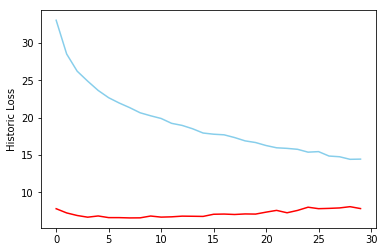

In [25]:
import matplotlib.pyplot as plt
plt.plot(train_loss_hist, color='skyblue')
plt.plot(eval_loss_hist, color='red')
plt.ylabel('Historic Loss')
plt.show()

In [26]:
model_path = 'pytorch_isear_dense_elmo_model.h5'
weight_path = 'pytorch_isear_dense_elmo_weights.h5'

torch.save(model.state_dict(), weight_path)
torch.save(model, model_path)

/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ElmoClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [27]:
test_loss, test_pred, test_target = evaluate(model, test_loader, device, loss_fn)

/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Evaluate: Average loss: 16.6365, Accuracy: 1237/2300 (53%)



In [28]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

cf_matrix = confusion_matrix(test_target, test_pred)

df_cm = pd.DataFrame(
    cf_matrix, index=labels, columns=labels, 
)

df_cm

,anger,disgust,fear,guilt,joy,sadness,shame
anger,135,52,7,52,12,21,50
disgust,59,192,10,24,8,13,23
fear,28,27,192,30,14,26,11
guilt,47,23,10,166,6,18,58
joy,12,18,5,17,238,21,17
sadness,38,23,12,33,25,185,13
shame,36,34,9,91,12,18,129


In [29]:
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Figure(288x216)


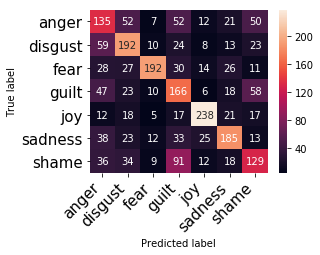

In [30]:
print(print_confusion_matrix(cf_matrix, class_names=labels))

In [31]:
test_accuracy = accuracy_score(test_target, test_pred)
print("test accuracy:", test_accuracy)

test accuracy: 0.5378260869565218


### Performance score for each classes

In [32]:
precision, recall, fscore, support = precision_recall_fscore_support(test_target, test_pred)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=labels)
score_df

,precision,recall,f1-score,support
anger,0.3803,0.4103,0.3947,329
disgust,0.5203,0.5836,0.5501,329
fear,0.7837,0.5854,0.6702,328
guilt,0.4019,0.5061,0.4480,328
joy,0.7556,0.7256,0.7403,328
sadness,0.6126,0.5623,0.5864,329
shame,0.4286,0.3921,0.4095,329


### Cohen Kappa Score

In [33]:
from sklearn.metrics import cohen_kappa_score

kappa_score = cohen_kappa_score(test_target, test_pred)
print("kappa:", kappa_score)

kappa: 0.4607955895024406
